<a href="https://colab.research.google.com/github/Sachini007/Data-Storm-3.0/blob/main/03-26/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adadelta,Adam,RMSprop 
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.utils import np_utils
import itertools
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dropout

# load data

In [ ]:
file_name = 'train_data.csv'
train_df = pd.read_csv(file_name)
print(train_df.shape)
train_df.head()


(19921, 4)


,CategoryCode,ItemCode,DateID,DailySales
0,category_2,117610,11/6/2021,7
1,category_4,836584,11/18/2021,16
2,category_1,370195,1/24/2022,6
3,category_2,172582,10/30/2021,5
4,category_2,1006009,10/30/2021,5


In [ ]:
validation_df = pd.read_csv('validation_data.csv')
print(validation_df.shape)
validation_df.head()

(370, 4)


,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,w1,11
1,category_2,1105009,w1,11
2,category_2,913561,w4,5
3,category_1,1048975,w4,30
4,category_1,17287,w2,60


# Daily Sales distribution

In [ ]:
train_df['DailySales_bins']=pd.cut(train_df.DailySales,[0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,100,150,200,250,300,350,400,450])
print('Max sale:', train_df.DailySales.max())
print('Min sale:', train_df.DailySales.min())
print('Avg sale:', train_df.DailySales.mean())
print('Total sale:', train_df.DailySales.sum())

Max sale: 434
Min sale: 1
Avg sale: 7.351889965363185
Total sale: 146457


In [ ]:
pd.value_counts(train_df.DailySales_bins)

(0, 1]        4413
(1, 2]        3503
(2, 3]        2376
(3, 4]        1887
(10, 20]      1868
(4, 5]        1297
(5, 6]        1026
(6, 7]         770
(7, 8]         583
(20, 30]       551
(8, 9]         480
(9, 10]        428
(50, 100]      304
(30, 40]       202
(40, 50]       128
(100, 150]      83
(150, 200]      15
(200, 250]       4
(250, 300]       1
(300, 350]       1
(400, 450]       1
(350, 400]       0
Name: DailySales_bins, dtype: int64

<AxesSubplot:title={'center':'Sales distribution'}>

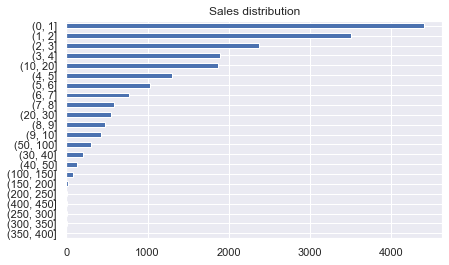

In [ ]:
sales_count = pd.value_counts(train_df.DailySales_bins)
sales_count.sort_values(ascending=True).plot(kind='barh', title='Sales distribution', )

In [ ]:
total_points = pd.value_counts(train_df.DailySales_bins).sum()
pd.value_counts(train_df.DailySales_bins).apply(lambda s: (s/total_points)*100)

(0, 50]       97.946890
(50, 100]      1.526028
(100, 150]     0.416646
(150, 200]     0.075297
(200, 250]     0.020079
(250, 300]     0.005020
(300, 350]     0.005020
(400, 450]     0.005020
(350, 400]     0.000000
Name: DailySales_bins, dtype: float64

# Sales variation across category

In [ ]:
sales_pivoted_df = pd.pivot_table(train_df, index='CategoryCode', values=['DailySales','DateID'], columns='ItemCode', aggfunc=np.mean)
sales_pivoted_df

DailySales                                                    \
ItemCode        3418      3427      7666      9925      16936     17287     
CategoryCode                                                                
category_1     9.829457  6.538462       NaN       NaN       NaN  4.293478   
category_2          NaN       NaN       NaN  2.479167       NaN       NaN   
category_3          NaN       NaN  14.80531       NaN  8.135135       NaN   
category_4          NaN       NaN       NaN       NaN       NaN       NaN   

                                                         ...            \
ItemCode        17296      20824      23200     23569    ...   1098502   
CategoryCode                                             ...             
category_1    71.191176        NaN        NaN       NaN  ...       NaN   
category_2          NaN  18.647059        NaN  3.530973  ...  1.594937   
category_3          NaN        NaN        NaN       NaN  ...       NaN   
category_4          NaN        NaN  13.860759       NaN  ...       NaN   

                                                                        \
ItemCode       1101553   1101562 1101571   1101661   1101769   1103056   
CategoryCode                                                             
category_1         NaN       NaN     NaN       NaN       NaN       NaN   
category_2    1.906667  2.265957     4.8       NaN  2.921053  2.826923   
category_3         NaN       NaN     NaN  6.205607       NaN       NaN   
category_4         NaN       NaN     NaN       NaN       NaN       NaN   

                                            
ItemCode       1105009   1105018   1105027  
CategoryCode                                
category_1         NaN       NaN       NaN  
category_2    1.898551  1.863636  1.961538  
category_3         NaN       NaN       NaN  
category_4         NaN       NaN       NaN  

[4 rows x 194 columns]

In [ ]:
sales_across_store_df = sales_pivoted_df.copy()
sales_across_store_df['AvgDailySale'] = sales_across_store_df.apply(lambda r: r.mean(), axis=1)
sales_across_store_df['AvgDailySale']


CategoryCode
category_1     6.280729
category_2     4.139096
category_3    10.856383
category_4    15.820818
Name: AvgDailySale, dtype: float64

In [ ]:
# Scatter plot of average sales per store
sales_store_data = go.Scatter(
    y = sales_across_store_df.AvgDailySale.values,
    mode='markers',
    marker=dict(
        size = sales_across_store_df.AvgDailySale.values,
        color = sales_across_store_df.AvgDailySale.values,
        colorscale='Viridis',
        showscale=True
    ),
    text = sales_across_store_df.index.values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg Daily sales per Category',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Category',
        ticklen= 4,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Daily Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_store_layout)
py.iplot(fig,filename='scatter_sales_store')

# Sales variation across item

In [ ]:
    sales_across_item_df = sales_pivoted_df.copy()
    # Aggregate the sales per item and add it as a new row in the same dataframe
    sales_across_item_df.loc[11] = sales_across_item_df.apply(lambda r: r.mean(), axis=0)
    # Note the 11th index row, which is the average sale of each of the item across all the stores
    #display(sales_across_item_df.loc[11:])
    avg_sales_per_item_across_stores_df = pd.DataFrame(data=[[i+1,a] for i,a in enumerate(sales_across_item_df.loc[11:].values[0])], columns=['ItemID', 'AvgDailySale'])
    # And finally, sort by avg sale
    avg_sales_per_item_across_stores_df.sort_values(by='AvgDailySale', ascending=False, inplace=True)
    # Display the top 10 rows
    avg_sales_per_item_across_stores_df.head(10)

,ItemID,AvgDailySale
60,61,89.355556
49,50,71.310606
6,7,71.191176
157,158,34.094118
48,49,22.742647
90,91,22.442478
54,55,22.213235
18,19,20.066667
7,8,18.647059
121,122,18.029851


In [ ]:
avg_sales_per_item_across_stores_sorted = avg_sales_per_item_across_stores_df.AvgDailySale.values
# Scatter plot of average sales per item
sales_item_data = go.Bar(
    x=[i for i in range(0, 200)],
    y=avg_sales_per_item_across_stores_sorted,
    marker=dict(
        color=avg_sales_per_item_across_stores_sorted,
        colorscale='Blackbody',
        showscale=True
    ),
    text = avg_sales_per_item_across_stores_df.ItemID.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 200,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
py.iplot(fig,filename='scatter_sales_item')

# time series visualization of sales

In [ ]:
store_item_df = train_df.copy()
# First, let us filterout the required data
item_id = 117610   # Some item
print('Before filter:', store_item_df.shape)
store_item_df = store_item_df[store_item_df.ItemCode == item_id]
print('After filter:', store_item_df.shape)
store_item_df.head()

store_item_ts_data = [go.Scatter(
        x=store_item_df.DateID,
        y=store_item_df.DailySales)]
py.iplot(store_item_ts_data)
    

Before filter: (19921, 5)
After filter: (100, 5)


# LIGHTGBM

In [ ]:
train_df.columns

Index(['CategoryCode', 'ItemCode', 'DateID', 'DailySales', 'DailySales_bins',
       'month', 'day', 'year'],
      dtype='object')

In [ ]:
train_df['DateID'] = pd.to_datetime(train_df['DateID'])
#validation_df['date'] = pd.to_datetime(train_df['date'])

train_df['month'] = train_df['DateID'].dt.month
train_df['day'] = train_df['DateID'].dt.dayofweek
train_df['year'] = train_df['DateID'].dt.year

'''validation_df['month'] = validation_df['date'].dt.month
validation_df['day'] = validation_df['date'].dt.dayofweek
validation_df['year'] = validation_df['date'].dt.year'''

col = [i for i in train_df.columns if i not in ['DateID','CategoryCode','DailySales_bins']]
y = 'DailySales'
train_x, test_x, train_y, test_y = train_test_split(train_df[col],train_df[y], test_size=0.2, random_state=2018)

In [ ]:
train_x.shape, test_x.shape

((15936, 5), (3985, 5))

In [ ]:
#reshape
train_x = np.array(train_x).reshape(train_x.shape[0], 1, train_x.shape[1])
test_x = np.array(test_x).reshape(test_x.shape[0], 1, test_x.shape[1])
train_x.shape,test_x.shape

((15936, 1, 5), (3985, 1, 5))

In [ ]:
train_x

array([[[ 877624,       6,      10,       3,    2021]],

       [[1030948,       1,      11,       2,    2021]],

       [[1047967,      11,       1,       0,    2022]],

       ...,

       [[ 124774,       5,      11,       1,    2021]],

       [[  17287,       1,       2,       2,    2022]],

       [[ 216151,       1,      11,       1,    2021]]], dtype=int64)

In [ ]:
train_x = np.asarray(train_x).astype('float32')

In [ ]:
_optimiser = ['Adam','Nadam','RMSprop']
model = Sequential()
model.add(LSTM(144, batch_input_shape=(32, 1, 5), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=_optimiser[0])
model.summary()
model.fit(train_x,train_y, batch_size=32,epochs=25)
#submission = pd.read_csv("../input/demand-forecasting-kernels-only/sample_submission.csv")
#submission['sales'] = model.predict(test_x)
#submission.to_csv("submission_Adam")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (32, 144)                 86400     
_________________________________________________________________
dense_5 (Dense)              (32, 1)                   145       
Total params: 86,545
Trainable params: 86,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
498/498 [==============================] - 2s 2ms/step - loss: 208.9823
Epoch 2/25
498/498 [==============================] - 1s 2ms/step - loss: 208.7965
Epoch 3/25
498/498 [==============================] - 1s 2ms/step - loss: 214.2827
Epoch 4/25
498/498 [==============================] - 1s 2ms/step - loss: 209.2308
Epoch 5/25
498/498 [==============================] - 1s 2ms/step - loss: 200.6652
Epoch 6/25
498/498 [==============================] - 1s 2ms/step - loss: 190.2348
Epoch 7/25
498